<h1> Chest X-Ray Image Classification of Pneumonia Diagnoses using Deep Learning Modeling CNNs </h1>

Authors: Ilan Haskel, Justin James, Roshni Janakiraman, Leif Schultz, and Brandon Sienkiewicz

---

A random state within Numpy and Tensorflow was specified in order to try to reproduce the below results. Unfortunately, due to the complexity of some of the later models, it does not seem to work as intended.

In [31]:
from numpy.random import seed
seed(72)
import tensorflow as tf
tf.random.set_seed(72)

Project Overview

# Business Understanding

**Stakeholder:** Children's Hospital - Board of Directors

## Business Case 

Pneumonia is the primary cause of childhood hospitalization [[1]](https://pubmed.ncbi.nlm.nih.gov/25695124/). Pediatric pneumonia is lethal without proper treatment, accounting for 15% of all childhood deaths [[2]](https://www.who.int/en/news-room/fact-sheets/detail/pneumonia).  As the disease progresses, pediatric pneumonia requires a significant amount of hospital resources for treatment and poses a high cost of care for patients [[3]](https://www.sciencedirect.com/science/article/pii/S2352646719300274). Therefore, timely and accurate diagnosis of pneumonia is critical for successful treatment.

There are many complications to quickly and accurately diagnosing pneumonia. To determine the right treatment protocol, doctors need to determine whether pneumonia is *bacterial* or *viral* [[4]](https://www.nejm.org/doi/full/10.1056/NEJMoa1405870). Clinical features alone are not sufficient to accurately diagnose pneumonia [[5]](https://pneumonia.biomedcentral.com/articles/10.15172/pneu.2014.5/464#Sec4).

Chest X-Ray evaluation is the current gold standard for diagnosing pneumonia [[6]](https://academic.oup.com/cid/article/31/2/347/293404). However, this method has key limitations. Chest X-ray interpretation is labor intensive and prone to human error; there is a shortage of radiologists with sufficient training to read chest X-rays[[7]](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(21)00106-0/fulltext). Even for experienced radiologists, reliability and accuracy scores range from 38-76% [[8]](https://www.ajronline.org/doi/10.2214/AJR.19.21521).

Artificial Intelligence can improve the process of diagnosing pneumonia accurately and efficiently. Computer aided diagnostic systems have shown reasonable accuracy in detecting infections from X-rays. When aided by AI, radiologists are significantly more accurate at diagnosing pneumonia compared to unassisted[[9]](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(21)00106-0/fulltext). Computerized models can increase the overall efficiency of the diagnostic process by reducing work burden on radiologists. Quicker detection allows doctors to start treatment protocol sooner, which can reduce severity and duration of illness.  

## Goals of Current Project

We sought to create and optimize image classification models that could diagnose pneumonia from chest X-ray images. Our specific goals for these models were to:

1. Accurately distinguish pneumonia *positive* cases from *negative cases*
2. Given a new chest X-Ray image, accurately classify case as *bacterial pneumonia,* *viral pneumonia* or *non-pneumonia*
3. Minimize *false negative* diagnoses, given lethality of pneumonia without proper treatment
4. Increase the efficiency of the chest X-ray diagnostic process by deploying a quick, simple-to-run testing system.

---

## Data Understanding

### Data Source

Originating from a larger study [[11]](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5), this project's data consists of Chest X-Ray Images from pediatric patients (ages 1-5) at Guangzhou Women and Children’s Medical Center, taken as part of patients’ routine clinical care. We used a subset of this data, obtained from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), and reorganized the data into 3 folders (Bacterial/Viral/Normal).

The current dataset consists of 5,863 Chest X-Ray images (JPEG).

### Data Exploration


Before reading in the data, we import all relevant packages. Since our data consists of images, we utilize the `image_dataset_from_directory` from Tensorflow. In order to use this data for analysis, the data was instantiated as images and labels and then converted to a Numpy array as it is an easier data type to work with.

In [2]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='D:/Flatiron/X-Ray_pneumonia__phase_4/data',
    batch_size=10000,
    seed=4356    
)

Found 5856 files belonging to 3 classes.


In [4]:
images, labels = next(iter(data))

In [5]:
images, labels = np.array(images), np.array(labels)

### Data Quality

In the [original study](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5), X-ray images were screened for quality control and graded by two expert physicians before being cleared for training the AI system. 

---

## Data Preparation

The data as given already contained a train, test split; however, the validation set did not appear to have any viral pneumonia photos in the validation set. The validation set was also very small, containing only sixteen total photos. In order to accurately test on unseen data, we combined the training, testing, and validation datasets and then conducted a train, test split to recreate each data set. We chose to do a split of 80% train, 10% test, and 10% validation as it appears to be a generally acceptable proportion for a train test split. This new split allows for more meaningful evaluation when trying to accurately predict bacterial pneumonia, viral pneumonia, and non-pneumonia.

In [6]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images,
    labels,
    random_state=42,
    test_size=585
)

In [7]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images,
    train_labels,
    random_state=42,
    test_size=585
)

In [8]:
train_images.shape

(4686, 256, 256, 3)

In [9]:
test_images.shape

(585, 256, 256, 3)

In [10]:
val_images.shape

(585, 256, 256, 3)

With our new train,test split, it appears that bacterial pneumonia is the dominate class, at roughly 47.5%, followed by the non-pneumonia class at roughly 26.5%, and finally the viral pneumonia class at roughly 26%. This data does not appear to be unbalanced and, therefore, should not need any upsampling. Since no upsampling is needed, the next step is to normalize the image matrices. Since our images are 256x256 pixels, we divide the entries by 255 to normalize. This process makes each entry's value, or pixel, between 0 and 1. 

In [11]:
pd.DataFrame(train_labels).value_counts(normalize=True)

1    0.469910
0    0.270593
2    0.259496
dtype: float64

In [12]:
train_images, test_images, val_images = train_images/255, test_images/255, val_images/255

Finally, since we are evaluating a multiclass classification problem, we need to transform our labels with `OneHotEncoder`. This process splits the labels binary columns that state which class a given image is. Following this process, the data is ready for modelling.

In [13]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

train_labels_encoded = ohe.fit_transform(train_labels.reshape(-1, 1)).toarray()

test_labels_encoded = ohe.fit_transform(test_labels.reshape(-1, 1)).toarray()

val_labels_encoded = ohe.fit_transform(val_labels.reshape(-1, 1)).toarray()

---

## Data Modeling

Before starting the modelling, a function titled `evaluate` was created to visualize the results of each model. This function takes the model and the results and prints out the following visualizations: loss for the training and validation set, accuracy for the training and validation set, a confusion matrix for the multiclass problem, the accuracy for each class in the multiclass, a confusion matrix for the binary problem, and the accuracy for each class in the binary. The function is detailed below.

In [48]:
def evaluate(model, results, final=False):
    
    #Create a function that provides useful vis for model
    #performance. This is especially useful as we are most
    #concerned with the number of false negatives
    
    if final:
        val_label="test"
    else:
        val_label="validation"
        

    #Extracts metrics from the results of the model (model fitting)
    
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    #Setting up the plots
    
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 10))

    # Plotting loss
    ax1.set_title("Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label)
    ax1.legend()

    # Plotting accuracy
    
    ax2.set_title("Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label="train")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label=val_label)
    ax2.legend()
    
    #Uses the model to make predictions and creates a confusion
    #matrix for the multiclass
    
    y_pred = model.predict(test_images)
    cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
    cm_df = pd.DataFrame(cm)
    
    #Plotting the multiclass confusion matrix

    sns.heatmap(cm, ax=ax3, annot=True, cmap='Blues', fmt='0.5g')
    
    #Setting up the barplot showing the accuracy of each class
    #This involves creating labels and heights for the plot
    #The heights are determined from the values in the confusion
    #matrix

    label = ['Healthy Accuracy',
             'Bacterial Accuracy',
             'Viral Accuracy']

    height = [(cm_df[0][0]/sum(cm_df[0]))*100,
              (cm_df[1][1]/sum(cm_df[1]))*100,
              (cm_df[2][2]/sum(cm_df[2]))*100]
    
    #Plotting the class accuracy

    ax4.bar(x=label, height=height)
    plt.sca(ax4)
    xlocs, xlabs = plt.xticks()
    plt.ylim(top=100)
    plt.ylabel('Accuracy Percentage')
    plt.title('Model Accuracy')
    for i, j in enumerate(height):
        ax4.text(xlocs[i],
                 j-30,
                 ((str(round(j,1)))+'%'),
                 ha ='center',
                 bbox = dict(facecolor = 'white', alpha = .5))
        
    #Using the previous confusion matrix to create a binary
    #Confusion matrix
        
    cm_simple = [[cm_df[0][0], cm_df[1][0]+cm_df[2][0]],
                 [cm_df[0][1]+cm_df[0][2], cm_df[1][1]+cm_df[1][2]+cm_df[2][1]+cm_df[2][2]]]
    cm_simple_df = pd.DataFrame(cm_simple)
    
    #Plotting the binary confusion matrix
    
    sns.heatmap(cm_simple, ax=ax5, annot=True, cmap='Blues', fmt='0.5g')
    
    #Setting up the barplot showing the accuracy of each class
    #This involves creating labels and heights for the plot
    #The heights are determined from the values in the confusion
    #matrix
    
    simple_label = ['Healthy\n Accuracy',
                    'Pneumonia\n Accuracy']
    
    simple_height = [(cm_simple_df[0][0]/sum(cm_simple_df[0]))*100,
                     (cm_simple_df[1][1]/sum(cm_simple_df[1]))*100]
    
    #Plotting the class accuracy
    
    ax6.bar(x=simple_label, height=simple_height)
    plt.sca(ax6)
    xlocs, xlabs = plt.xticks()
    plt.ylim(top=100)
    plt.ylabel('Accuracy Percentage')
    plt.title('Model Accuracy')
    for k, l in enumerate(simple_height):
        ax6.text(xlocs[k],
                 l-30,
                 ((str(round(l,1)))+'%'),
                 ha ='center',
                 bbox = dict(facecolor = 'white', alpha = .5))

#### Baseline Model (Iteration One)

For the baseline model, a sequential model was chosen. The parameters chosen were chosen in order to prevent the model from having too many nodes. The input layer is a 2D convolutional layer with a 2x2 convolutional window and a dimensionality of 64. The activation used is relu. Padding was added in order to accomodate more layers in the future. The first hidden layer is a 2D max pooling layer which downsamples the input. The next hidden layers are a 2D convolutional layer with a dimensionality of 32 followed by a 2D max pooling layer. These layers are repeated once more except the following 2D convolutional layer has a dimensionality of 16. A flattening layer is then added, followed by a dense layer with dimensionality of 500. This will likely cause overfitting; however, since this is a baseline model, we can tune this in future iterations. The output layer is a dense layer with dimensionality 3. The filter was set to 3 as there are 3 category outputs for the model.

In [15]:
baseline = models.Sequential()

baseline.add(layers.Conv2D(filters=64,
                           kernel_size=2,
                           padding="same",
                           activation="relu",
                           input_shape=(256,256,3)))

baseline.add(layers.MaxPooling2D(pool_size=2))

baseline.add(layers.Conv2D(filters=32,
                           kernel_size=2,
                           padding="same",
                           activation ="relu"))
baseline.add(layers.MaxPooling2D(pool_size=2))
baseline.add(layers.Conv2D(filters=16,
                           kernel_size=2,
                           padding="same",
                           activation="relu"))
baseline.add(layers.MaxPooling2D(pool_size=2))

baseline.add(layers.Flatten())

baseline.add(layers.Dense(500,activation="relu"))

baseline.add(layers.Dense(3,activation="softmax"))

Following model creating, the model was compiled using `adam` as the optimizer and `categorical_crossentropy` as the loss metric. `categorical_crossentropy` was chosen as `train_labels` is not a sparse matrix, but rather, a Numpy array. `accuracy` was chosen for the metric as it most closely fits our evaluation metric. The confusion matrices will be the best indicator of model performance as we are looking to minimize the false negatives. 

In [16]:
baseline.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

results = baseline.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=10,
    batch_size=128)

Epoch 1/10
37/37 [==============================] - 82s 2s/step - loss: 1.1336 - accuracy: 0.5670 - val_loss: 0.8149 - val_accuracy: 0.6564
Epoch 2/10
37/37 [==============================] - 82s 2s/step - loss: 0.6040 - accuracy: 0.7516 - val_loss: 0.6392 - val_accuracy: 0.7641
Epoch 3/10
37/37 [==============================] - 81s 2s/step - loss: 0.5025 - accuracy: 0.7894 - val_loss: 0.5998 - val_accuracy: 0.7709
Epoch 4/10
37/37 [==============================] - 82s 2s/step - loss: 0.4555 - accuracy: 0.8092 - val_loss: 0.5555 - val_accuracy: 0.7778
Epoch 5/10
37/37 [==============================] - 82s 2s/step - loss: 0.4169 - accuracy: 0.8216 - val_loss: 0.6079 - val_accuracy: 0.7692
Epoch 6/10
37/37 [==============================] - 83s 2s/step - loss: 0.4069 - accuracy: 0.8269 - val_loss: 0.5631 - val_accuracy: 0.7692
Epoch 7/10
37/37 [==============================] - 82s 2s/step - loss: 0.3840 - accuracy: 0.8397 - val_loss: 0.5634 - val_accuracy: 0.7863
Epoch 8/10
37/37 [==

The baseline model completed with an accuracy of 87.0% on the training data and 77.1% on the validation data. This model is obviously overfit which is clearly shown in the top two visualizations below. The model does do a decent job of predicting each type of pneumonia, 81.8% accuracy when predicting bacterial pneumonia and 60.2% predicting viral pneumonia. It appears that there are only 9 false negatives in this model, meaning the false omission rate rate is roughly 6.0%. This is a good start for the baseline model but overfitting can be reduced.

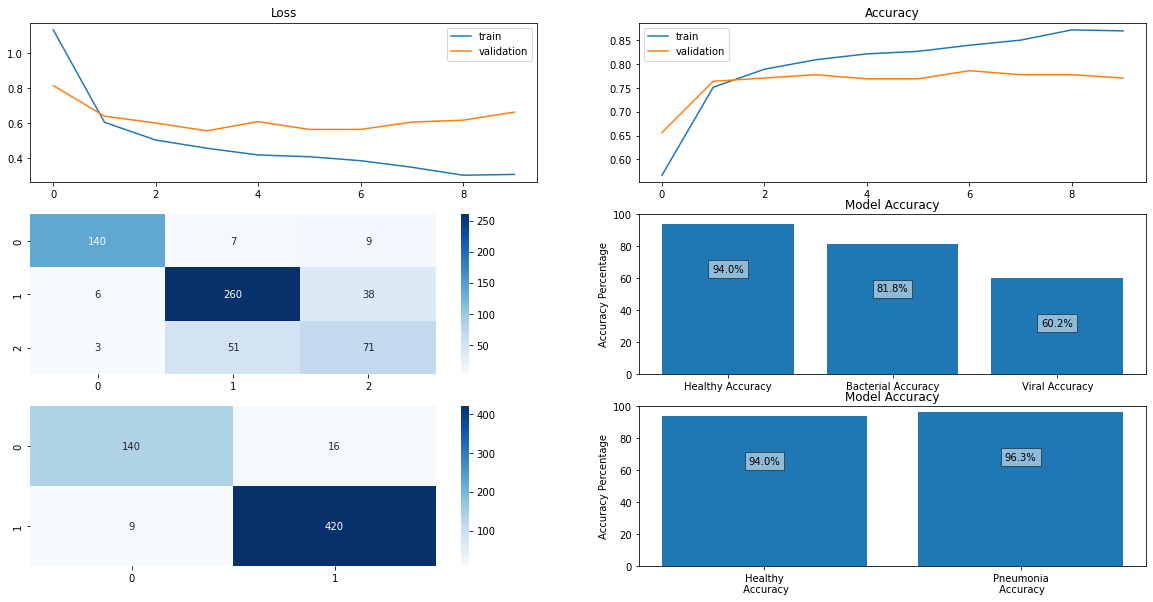

In [17]:
evaluate(baseline, results)

#### Second Model Iteration

For the second model iteration, the layers before the flattening layer were not changed. Instead of one dense layer following flattening, two dense layers with dimensionality 128 and 64 replace the layer. The model was compiled and fit in the same way as the `baseline`.

In [18]:
model2 = models.Sequential()

model2.add(layers.Conv2D(filters=64,
                         kernel_size=2,
                         padding="same",
                         activation="relu",
                         input_shape=(256,256,3)))

model2.add(layers.MaxPooling2D(pool_size=2))

model2.add(layers.Conv2D(32,
                         3,
                         padding="same",
                         activation ="relu"))
model2.add(layers.MaxPooling2D(pool_size=2))
model2.add(layers.Conv2D(16,
                         3,
                         padding="same",
                         activation="relu"))
model2.add(layers.MaxPooling2D(pool_size=2))

model2.add(layers.Flatten())

model2.add(layers.Dense(128,activation="relu"))
model2.add(layers.Dense(64,activation="relu"))
model2.add(layers.Dense(3,activation="softmax"))

In [19]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [20]:
results = model2.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=10,
    batch_size=128)

Epoch 1/10
37/37 [==============================] - 95s 3s/step - loss: 0.8114 - accuracy: 0.6347 - val_loss: 0.7132 - val_accuracy: 0.7402
Epoch 2/10
37/37 [==============================] - 98s 3s/step - loss: 0.5319 - accuracy: 0.7793 - val_loss: 0.7465 - val_accuracy: 0.7214
Epoch 3/10
37/37 [==============================] - 97s 3s/step - loss: 0.4736 - accuracy: 0.7934 - val_loss: 0.5749 - val_accuracy: 0.7624
Epoch 4/10
37/37 [==============================] - 98s 3s/step - loss: 0.4403 - accuracy: 0.8116 - val_loss: 0.5557 - val_accuracy: 0.7863
Epoch 5/10
37/37 [==============================] - 98s 3s/step - loss: 0.4169 - accuracy: 0.8207 - val_loss: 0.5933 - val_accuracy: 0.7624
Epoch 6/10
37/37 [==============================] - 104s 3s/step - loss: 0.4003 - accuracy: 0.8271 - val_loss: 0.5664 - val_accuracy: 0.7863
Epoch 7/10
37/37 [==============================] - 97s 3s/step - loss: 0.3633 - accuracy: 0.8427 - val_loss: 0.6115 - val_accuracy: 0.7744
Epoch 8/10
37/37 [=

This model appears to be extremely overfit, with over a 10% difference between training and validation data. This model does appear to do a good job on reducing false negatives, with a false omission rate of only 5.8%.

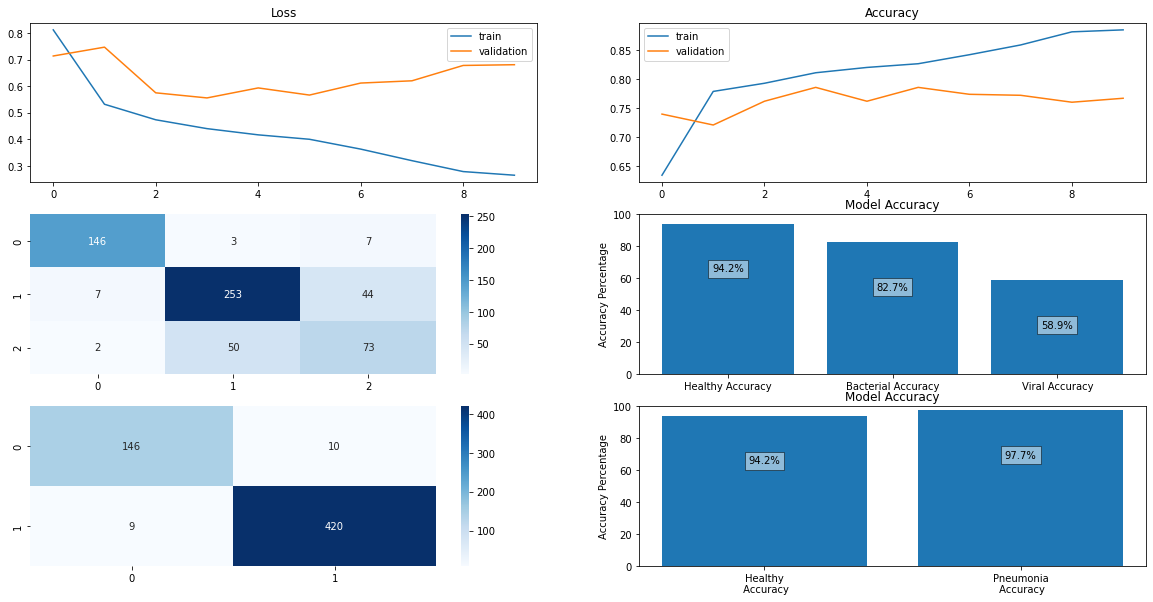

In [21]:
evaluate(model2, results)

#### Third Model Iteration

The third model adds a few layers and parameters. First, L2 regularization is added to the initial hidden 2D convolutional layers with a regularization factor of 0.05. Then 2D convolutional layers are added between the previous 2D convolutional layers and the max pooling layers. These have the same set-up as their previous layers with dimensionality 16 and 8 respectively. Also, in order to further reduce overfitting, the two previous dense layers after flattening were replaced with three dense layers of dimensionality 64, 32, and 16. The model was compiled and fit in the same way as the `baseline`.

In [22]:
model3 = models.Sequential()

model3.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

model3.add(layers.MaxPooling2D(pool_size=2))

model3.add(layers.Conv2D(filters=32,
                        kernel_size=2,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu"))
model3.add(layers.MaxPooling2D(pool_size=2))
model3.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu"))
model3.add(layers.MaxPooling2D(pool_size=2))

model3.add(layers.Flatten())

model3.add(layers.Dense(64,activation="relu"))
model3.add(layers.Dense(32,activation="relu"))
model3.add(layers.Dense(16,activation="relu"))
model3.add(layers.Dense(3,activation="softmax"))

In [23]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [24]:
results = model3.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=10,
    batch_size=128)

Epoch 1/10
37/37 [==============================] - 85s 2s/step - loss: 3.0420 - accuracy: 0.5154 - val_loss: 2.1605 - val_accuracy: 0.6821
Epoch 2/10
37/37 [==============================] - 85s 2s/step - loss: 1.6149 - accuracy: 0.7079 - val_loss: 1.3147 - val_accuracy: 0.7162
Epoch 3/10
37/37 [==============================] - 85s 2s/step - loss: 1.0244 - accuracy: 0.7672 - val_loss: 0.9522 - val_accuracy: 0.7385
Epoch 4/10
37/37 [==============================] - 84s 2s/step - loss: 0.8033 - accuracy: 0.7661 - val_loss: 0.8180 - val_accuracy: 0.7419
Epoch 5/10
37/37 [==============================] - 82s 2s/step - loss: 0.6836 - accuracy: 0.7800 - val_loss: 0.7164 - val_accuracy: 0.7726
Epoch 6/10
37/37 [==============================] - 83s 2s/step - loss: 0.6132 - accuracy: 0.7921 - val_loss: 0.6659 - val_accuracy: 0.7778
Epoch 7/10
37/37 [==============================] - 86s 2s/step - loss: 0.5672 - accuracy: 0.7964 - val_loss: 0.6581 - val_accuracy: 0.7658
Epoch 8/10
37/37 [==

As seen below, this model greatly reduced overfitting and had a false negative rate of 6.6% which is an improvement from the previous models. This model does not appear to be too overfit and also has a decent accuracy at predicting baterial and viral pneumonia, 79.0% and 63.5% respectively.

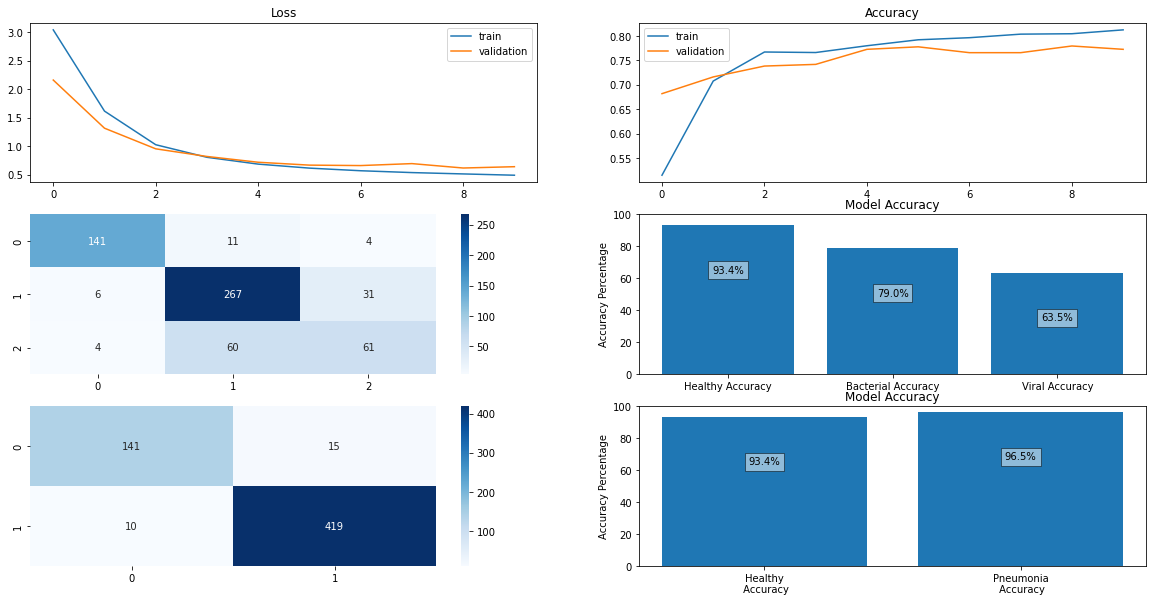

In [25]:
evaluate(model3, results)

#### Third Model (Second Iteration)

In order to try to improve this model, regularization was added to the two remaining hidden 2D convolutional layers and two 25% dropout layers were added. The model was compiled and fit in the same way as the `baseline`.

In [26]:
model3b = models.Sequential()

model3b.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

model3b.add(layers.MaxPooling2D(pool_size=2))

model3b.add(layers.Conv2D(filters=32,
                        kernel_size=2,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3b.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3b.add(layers.MaxPooling2D(pool_size=2))

model3b.add(layers.Dropout(0.25))

model3b.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3b.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3b.add(layers.MaxPooling2D(pool_size=2))

model3b.add(layers.Dropout(0.25))

model3b.add(layers.Flatten())

model3b.add(layers.Dense(64,activation="relu"))
model3b.add(layers.Dense(32,activation="relu"))
model3b.add(layers.Dense(16,activation="relu"))
model3b.add(layers.Dense(3,activation="softmax"))

In [27]:
model3b.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [28]:
results = model3b.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=10,
    batch_size=128)

Epoch 1/10
37/37 [==============================] - 85s 2s/step - loss: 4.3239 - accuracy: 0.4676 - val_loss: 3.0897 - val_accuracy: 0.5504
Epoch 2/10
37/37 [==============================] - 85s 2s/step - loss: 2.3754 - accuracy: 0.6554 - val_loss: 1.8074 - val_accuracy: 0.6667
Epoch 3/10
37/37 [==============================] - 85s 2s/step - loss: 1.4531 - accuracy: 0.7196 - val_loss: 1.2262 - val_accuracy: 0.6855
Epoch 4/10
37/37 [==============================] - 85s 2s/step - loss: 1.0589 - accuracy: 0.7177 - val_loss: 0.9679 - val_accuracy: 0.7094
Epoch 5/10
37/37 [==============================] - 85s 2s/step - loss: 0.8492 - accuracy: 0.7358 - val_loss: 0.8296 - val_accuracy: 0.7026
Epoch 6/10
37/37 [==============================] - 85s 2s/step - loss: 0.7702 - accuracy: 0.7311 - val_loss: 0.7777 - val_accuracy: 0.7111
Epoch 7/10
37/37 [==============================] - 85s 2s/step - loss: 0.6953 - accuracy: 0.7443 - val_loss: 0.7087 - val_accuracy: 0.7265
Epoch 8/10
37/37 [==

Unfortunately, this model did not perform as well. The model is not overfit and could likely use more training; however, the false omission rate is 12.5% which is more than double our previous model.

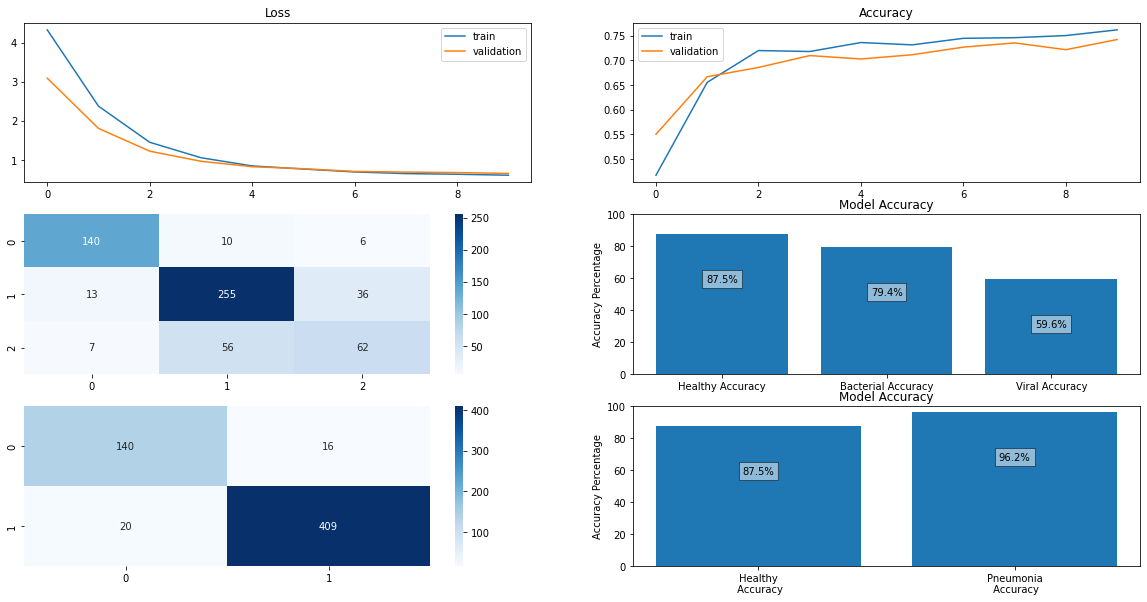

In [29]:
evaluate(model3b, results)

#### Fourth Model

This model removes a 25% dropout layer and adds a dense layer with dimensionality of 128 to the first iteration of the third model. The model was compiled and fit in the same way as the `baseline`.

In [52]:
model4 = models.Sequential()

model4.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

model4.add(layers.MaxPooling2D(pool_size=2))

model4.add(layers.Conv2D(filters=32,
                        kernel_size=3,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4.add(layers.MaxPooling2D(pool_size=2))

model4.add(layers.Dropout(0.25))

model4.add(layers.Conv2D(filters=16,
                        kernel_size=3,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4.add(layers.MaxPooling2D(pool_size=2))

model4.add(layers.Flatten())

model4.add(layers.Dense(128,activation="relu"))
model4.add(layers.Dense(64,activation="relu"))
model4.add(layers.Dense(32,activation="relu"))
model4.add(layers.Dense(16,activation="relu"))
model4.add(layers.Dense(3,activation="softmax"))

In [53]:
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [54]:
results = model4.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=10,
    batch_size=128)

Epoch 1/10
37/37 [==============================] - 105s 3s/step - loss: 4.0572 - accuracy: 0.4966 - val_loss: 2.7267 - val_accuracy: 0.5453
Epoch 2/10
37/37 [==============================] - 105s 3s/step - loss: 1.9672 - accuracy: 0.6729 - val_loss: 1.5089 - val_accuracy: 0.6718
Epoch 3/10
37/37 [==============================] - 105s 3s/step - loss: 1.1965 - accuracy: 0.7296 - val_loss: 1.0796 - val_accuracy: 0.6769
Epoch 4/10
37/37 [==============================] - 105s 3s/step - loss: 0.9268 - accuracy: 0.7288 - val_loss: 0.8472 - val_accuracy: 0.7111
Epoch 5/10
37/37 [==============================] - 105s 3s/step - loss: 0.7379 - accuracy: 0.7497 - val_loss: 0.7701 - val_accuracy: 0.6974
Epoch 6/10
37/37 [==============================] - 105s 3s/step - loss: 0.7031 - accuracy: 0.7433 - val_loss: 0.7320 - val_accuracy: 0.6974
Epoch 7/10
37/37 [==============================] - 105s 3s/step - loss: 0.6446 - accuracy: 0.7510 - val_loss: 0.6843 - val_accuracy: 0.7299
Epoch 8/10
37

This model does a decent job of predicting pneumonia at the cost of a higher false omission rate. 

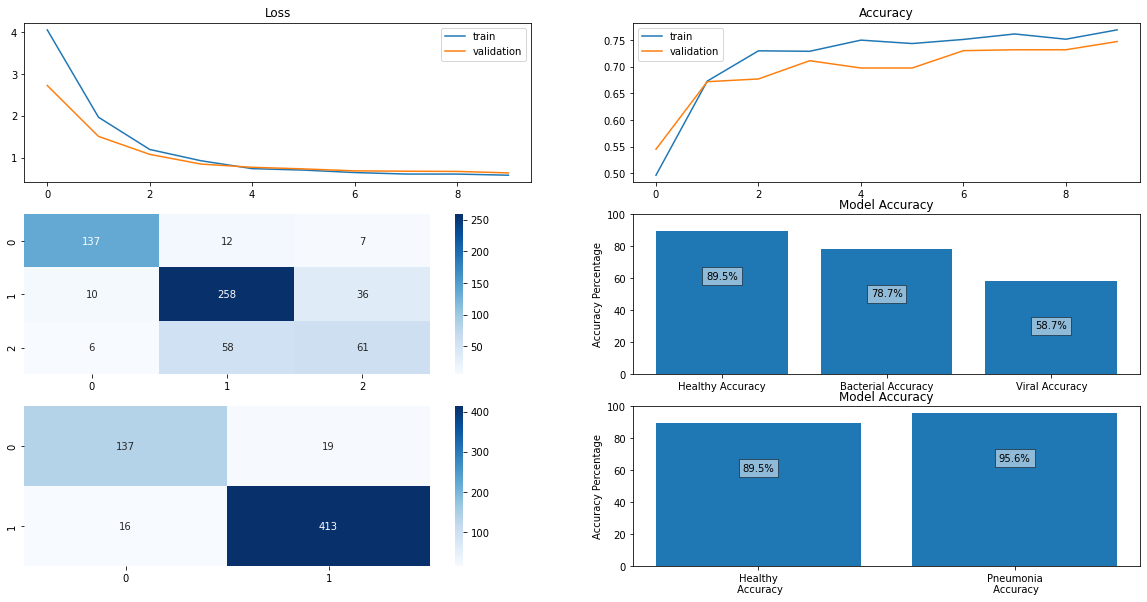

In [55]:
evaluate(model4, results)

#### Fourth Model (Second Iteration)

Since the previous model does not appear to have reached a minimum loss, an early stop was defined in order to reduce the loss and get a better fit. This model was fit with 50 epochs and will early stop when noticable improvements are not made for 5 iterations.

In [15]:
model4b = models.Sequential()

model4b.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

model4b.add(layers.MaxPooling2D(pool_size=2))

model4b.add(layers.Conv2D(filters=32,
                        kernel_size=3,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4b.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu",
                         kernel_regularizer=regularizers.L2(l=0.05)))
model4b.add(layers.MaxPooling2D(pool_size=2))

model4b.add(layers.Dropout(0.25))

model4b.add(layers.Conv2D(filters=16,
                        kernel_size=3,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4b.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu",
                         kernel_regularizer=regularizers.L2(l=0.05)))
model4b.add(layers.MaxPooling2D(pool_size=2))

model4b.add(layers.Flatten())

model4b.add(layers.Dense(128,activation="relu"))
model4b.add(layers.Dense(64,activation="relu"))
model4b.add(layers.Dense(32,activation="relu"))
model4b.add(layers.Dense(16,activation="relu"))
model4b.add(layers.Dense(3,activation="softmax"))

In [16]:
model4b.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [17]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=1e-8,
                           verbose=1,
                           mode='min',
                           patience=5)

In [18]:
results = model4b.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop]
)

Epoch 1/50
37/37 [==============================] - 102s 3s/step - loss: 4.2696 - accuracy: 0.4631 - val_loss: 3.1242 - val_accuracy: 0.4684
Epoch 2/50
37/37 [==============================] - 102s 3s/step - loss: 2.3843 - accuracy: 0.6046 - val_loss: 1.8270 - val_accuracy: 0.6769
Epoch 3/50
37/37 [==============================] - 102s 3s/step - loss: 1.4930 - accuracy: 0.7166 - val_loss: 1.2941 - val_accuracy: 0.7162
Epoch 4/50
37/37 [==============================] - 102s 3s/step - loss: 1.1413 - accuracy: 0.7279 - val_loss: 1.0560 - val_accuracy: 0.7009
Epoch 5/50
37/37 [==============================] - 102s 3s/step - loss: 0.9013 - accuracy: 0.7527 - val_loss: 0.9455 - val_accuracy: 0.6872
Epoch 6/50
37/37 [==============================] - 102s 3s/step - loss: 0.8023 - accuracy: 0.7525 - val_loss: 0.8045 - val_accuracy: 0.7282
Epoch 7/50
37/37 [==============================] - 105s 3s/step - loss: 0.7402 - accuracy: 0.7478 - val_loss: 0.7500 - val_accuracy: 0.7333
Epoch 8/50
37

Overall, this model performed fairly well; however, the final result is overfit. It does a good job of reducing false negatives with a false omission rate of only 5.5%. Unfortunately, due to overfitting, this model will not be used as the final model.

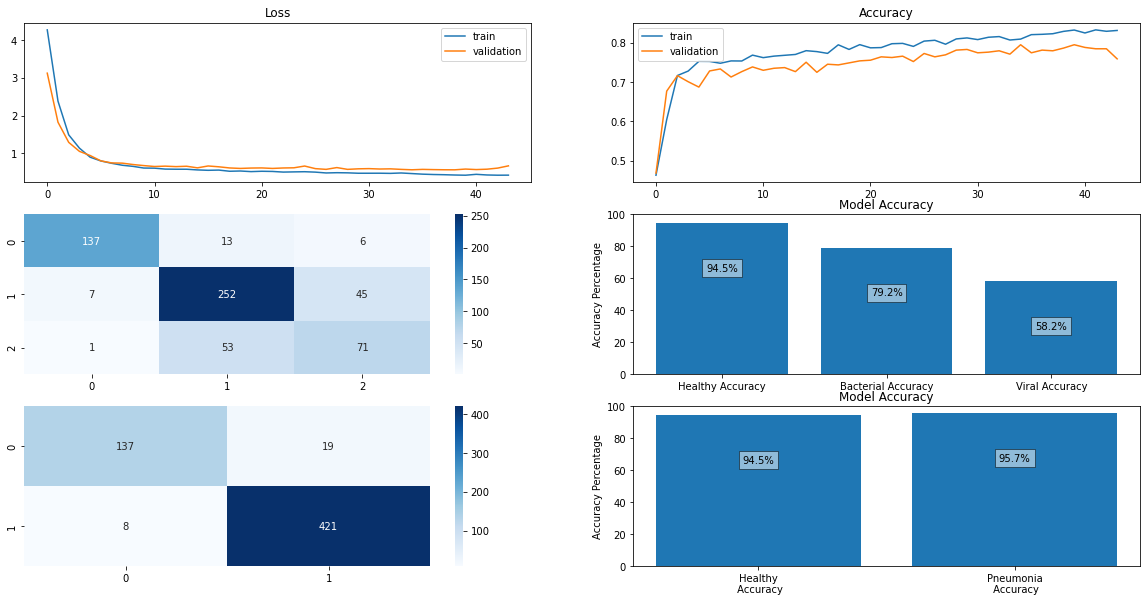

In [20]:
evaluate(model4b, results)

#### Fifth Model

This iteration of the model adds a dropout layer and early stopping to `model3` which performed the best out of all the models. This will be the final iteration before moving on to the `final_model`.

In [24]:
model5 = models.Sequential()

model5.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

model5.add(layers.MaxPooling2D(pool_size=2))

model5.add(layers.Conv2D(filters=32,
                        kernel_size=2,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model5.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu"))
model5.add(layers.MaxPooling2D(pool_size=2))

model5.add(layers.Dropout(0.25))

model5.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model5.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu"))
model5.add(layers.MaxPooling2D(pool_size=2))

model5.add(layers.Flatten())

model5.add(layers.Dense(64,activation="relu"))
model5.add(layers.Dense(32,activation="relu"))
model5.add(layers.Dense(16,activation="relu"))
model5.add(layers.Dense(3,activation="softmax"))

In [25]:
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [26]:
results = model5.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop]
)

Epoch 1/50
37/37 [==============================] - 83s 2s/step - loss: 3.0966 - accuracy: 0.4616 - val_loss: 2.3115 - val_accuracy: 0.6291
Epoch 2/50
37/37 [==============================] - 83s 2s/step - loss: 1.6597 - accuracy: 0.6596 - val_loss: 1.3027 - val_accuracy: 0.6547
Epoch 3/50
37/37 [==============================] - 83s 2s/step - loss: 1.0322 - accuracy: 0.7298 - val_loss: 0.9255 - val_accuracy: 0.7026
Epoch 4/50
37/37 [==============================] - 83s 2s/step - loss: 0.8037 - accuracy: 0.7429 - val_loss: 0.7703 - val_accuracy: 0.7248
Epoch 5/50
37/37 [==============================] - 83s 2s/step - loss: 0.6864 - accuracy: 0.7512 - val_loss: 0.7123 - val_accuracy: 0.7248
Epoch 6/50
37/37 [==============================] - 82s 2s/step - loss: 0.6244 - accuracy: 0.7659 - val_loss: 0.6652 - val_accuracy: 0.7470
Epoch 7/50
37/37 [==============================] - 83s 2s/step - loss: 0.5821 - accuracy: 0.7719 - val_loss: 0.6382 - val_accuracy: 0.7538
Epoch 8/50
37/37 [==

Overall, this is a solid model, though still somewhat overfit. The model does a good job of predicting bacterial pneumonia, 83.6%, and has a fairly low false omission rate of 7.8%.

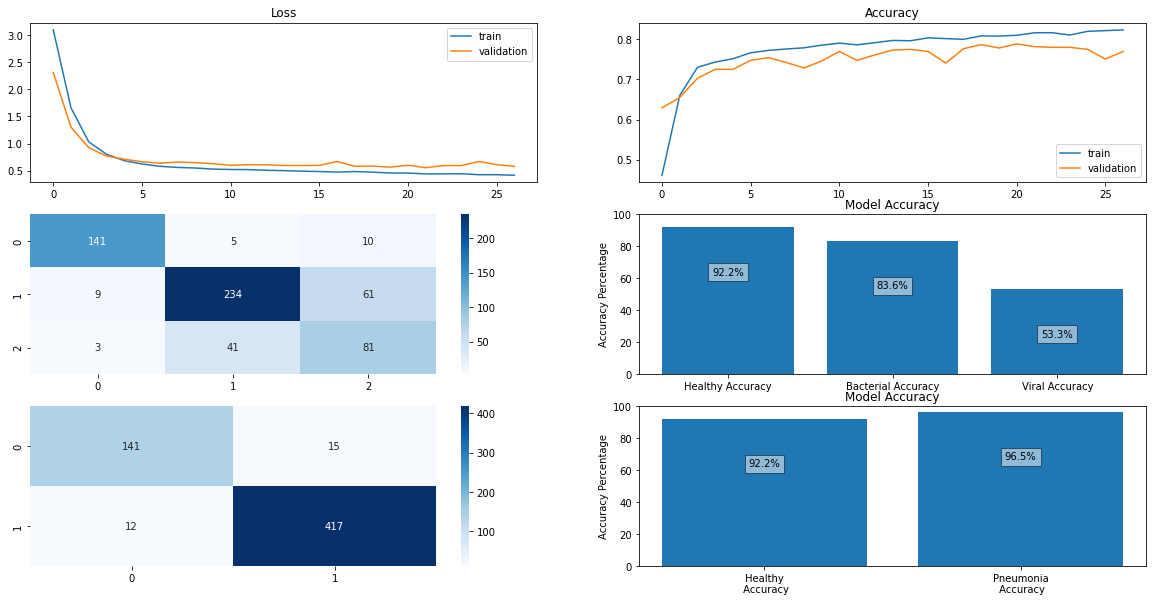

In [36]:
evaluate(model5, results)

#### Final Model

The base third model performed the best and; therefore, was chosen for the final model. The only addition made to this model was increasing the total epochs to 25 and adding in an early stopping. This early stop is defined slightly differently than the previous as they did not function exactly how intended. This early stop has a `min_delta` value of 1e-6 instead of 1e-8 and has a `patience` of 3 rather than 5. This should produce a well-fit model.

In [37]:
final_model = models.Sequential()

final_model.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

final_model.add(layers.MaxPooling2D(pool_size=2))

final_model.add(layers.Conv2D(filters=32,
                        kernel_size=2,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
final_model.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu"))
final_model.add(layers.MaxPooling2D(pool_size=2))
final_model.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
final_model.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu"))
final_model.add(layers.MaxPooling2D(pool_size=2))

final_model.add(layers.Flatten())

final_model.add(layers.Dense(64,activation="relu"))
final_model.add(layers.Dense(32,activation="relu"))
final_model.add(layers.Dense(16,activation="relu"))
final_model.add(layers.Dense(3,activation="softmax"))

In [38]:
final_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [39]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=1e-6,
                           verbose=1,
                           mode='min',
                           patience=3)

In [40]:
results = final_model.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=25,
    batch_size=128,
    callbacks=[early_stop]
)

Epoch 1/25
37/37 [==============================] - 83s 2s/step - loss: 3.0245 - accuracy: 0.5341 - val_loss: 2.2273 - val_accuracy: 0.5949
Epoch 2/25
37/37 [==============================] - 82s 2s/step - loss: 1.6788 - accuracy: 0.6908 - val_loss: 1.3575 - val_accuracy: 0.6940
Epoch 3/25
37/37 [==============================] - 82s 2s/step - loss: 1.1139 - accuracy: 0.7243 - val_loss: 0.9896 - val_accuracy: 0.7299
Epoch 4/25
37/37 [==============================] - 83s 2s/step - loss: 0.8366 - accuracy: 0.7691 - val_loss: 0.8373 - val_accuracy: 0.7248
Epoch 5/25
37/37 [==============================] - 83s 2s/step - loss: 0.7142 - accuracy: 0.7700 - val_loss: 0.7944 - val_accuracy: 0.7077
Epoch 6/25
37/37 [==============================] - 82s 2s/step - loss: 0.6682 - accuracy: 0.7695 - val_loss: 0.7022 - val_accuracy: 0.7470
Epoch 7/25
37/37 [==============================] - 82s 2s/step - loss: 0.6305 - accuracy: 0.7770 - val_loss: 0.6864 - val_accuracy: 0.7487
Epoch 8/25
37/37 [==

The final iteration of the model performed very well when predicting bacterial pneumonia at an accuracy of 82.1%. It also has the lowest rate for false negatives at just 7.1%. This model is slightly overfit but much less so than previous iterations of the model.

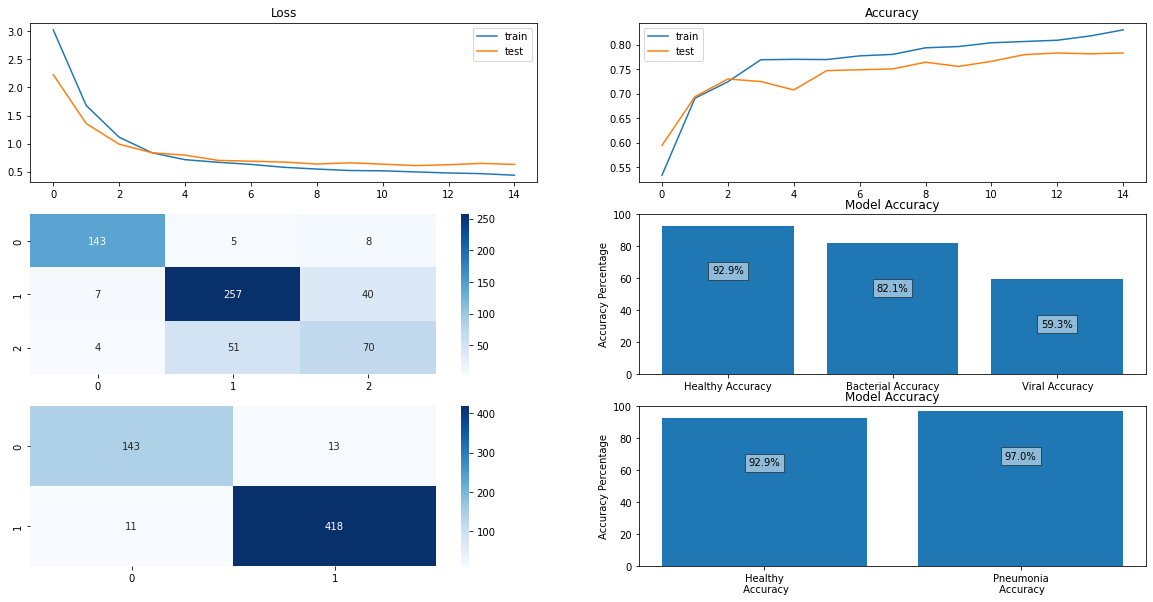

In [49]:
evaluate(final_model, results, final=True)
plt.savefig('../images/eval.png', bbox_inches='tight', dpi=300)

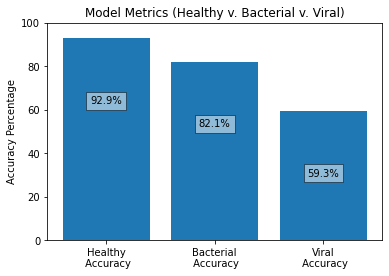

In [42]:
    y_pred = final_model.predict(test_images)
    cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
    cm_df = pd.DataFrame(cm)
    
    #Setting up the barplot showing the accuracy of each class
    #This involves creating labels and heights for the plot
    #The heights are determined from the values in the confusion
    #matrix

    label = ['Healthy\n Accuracy',
             'Bacterial\n Accuracy',
             'Viral\n Accuracy']

    height = [(cm_df[0][0]/sum(cm_df[0]))*100,
              (cm_df[1][1]/sum(cm_df[1]))*100,
              (cm_df[2][2]/sum(cm_df[2]))*100]
    
    #Plotting the class accuracy

    plt.bar(x=label, height=height)
    xlocs, xlabs = plt.xticks()
    plt.ylim(top=100)
    plt.ylabel('Accuracy Percentage')
    plt.title('Model Metrics (Healthy v. Bacterial v. Viral)')
    for i, j in enumerate(height):
        plt.text(xlocs[i],
                 j-30,
                 ((str(round(j,1)))+'%'),
                 ha ='center',
                 bbox = dict(facecolor = 'white', alpha = .5))
    
    plt.savefig('../images/class_accuracy.png', bbox_inches='tight', dpi=300)

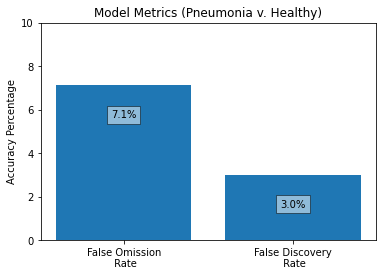

In [43]:
    label = ['False Omission\n Rate',
             'False Discovery\n Rate']
    
    height = [((cm_df[0][1]+cm_df[0][2])/(sum(cm_df[0])))*100,
              ((cm_df[1][0]+cm_df[2][0])/(sum(cm_df[1])+sum(cm_df[2])))*100]
    
    #Plotting some useful metrics using the information from above

    plt.bar(x=label, height=height)
    xlocs, xlabs = plt.xticks()
    plt.ylim(top=10)
    plt.ylabel('Accuracy Percentage')
    plt.title('Model Metrics (Pneumonia v. Healthy)')
    for i, j in enumerate(height):
        plt.text(xlocs[i],
                 j-1.5,
                 ((str(round(j,1)))+'%'),
                 ha ='center',
                 bbox = dict(facecolor = 'white', alpha = .5))
    
    plt.savefig('../images/fp_fn_rate.png', bbox_inches='tight', dpi=300)

## Model Evaluation and Deployment

### Healthy vs. Pneumonia

Our model is exceptionally good at identifying whether someone is healthy or not. With an accuracy of it 97 percent on unseen data, the model can predict whether or not someone has pneumonia based on their X-rays. Additionally, the false omission rate, the proportion of patients with pneumonia who were diagnosed as healthy, was minimized to just 7.1 percent. This means that a low number of potential pneumonia patients would slip through the cracks, especially after a final evaluation of the model results by a doctor. Overall, given that radiologist's accuracy rates range between 38-76 percent, this model can be a useful tool as an initial screening that can perform at similar rates to radiologists.

### Bacterial vs. Viral

One of the other advantages to our model is its ability to classify an x-ray as either a viral pneumonia infection or a bacterial infection. Our model was able to accurately predict bacterial pneumonia 82.1 percent of the time and was 59.3 percent accurate in predicting viral pneumonia. This can provide doctors with a good idea for correct treatment options given that nature of the pneumonia.

---

## Conclusion